In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.ndimage import generic_filter, gaussian_filter, median_filter
from skimage.morphology import erosion, disk
import marker_detection

%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (12, 7)

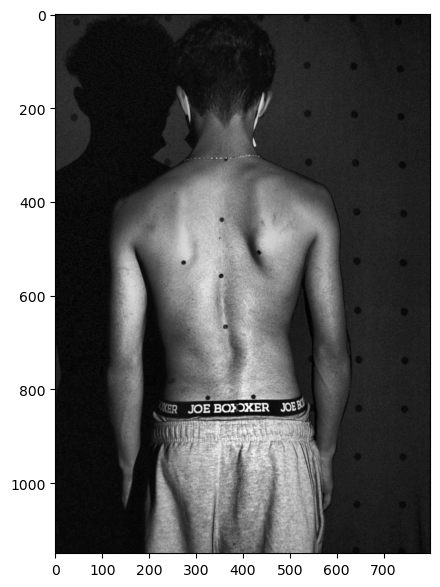

In [4]:
image = cv2.imread(r'D:\StageE23\Data\Ete_2022\Participant13\autocorrection\Prise01\intensity\auto_01_010651_I_0.jpg')
w1, w2, h1, h2 = 350, 1500, 200, 1000

image = marker_detection.preprocess(image, w1, w2, h1, h2)[0]

plt.imshow(image, cmap='gray')
plt.show()

In [5]:
w = image.shape[0]
h = image.shape[1]
im_std = generic_filter(image, np.std, 9, mode='nearest').reshape(w,h)
plt.imshow(im_std, cmap='gray')
plt.show()

In [1]:
mean = im_std.mean()
max = im_std.max()
print(mean, max)
im_crop = np.where(im_std > mean, 1, 0)
im_crop_g = gaussian_filter(im_crop, 7)
crop = np.where(im_crop_g == 1)
mid = int(len(crop[0])/2)
print(mid)
crop_y = crop[0][mid]
crop_x = crop[1][mid]
print(crop_y, crop_x)

image2 = image[crop_y-800:crop_y+80, crop_x-350:crop_x+250]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im_crop, cmap='gray')
ax2.imshow(im_crop_g, cmap='gray')
ax3.imshow(image2, cmap='gray')
plt.show()

NameError: name 'im_std' is not defined

In [17]:
path = r'D:\StageE23\Data\Ete_2022\Participant13\BD\Contraint\Prise01\BD_const_01_003575_I_0.raw'
header_size = 512
w = 1936
h = 1176

with open(path, 'r') as f:
    f.seek(header_size)
    # data = f.read()
    frame = np.fromfile(f, np.float32).reshape((h, w, 3))
    #retrieve the depth as an image (and flip upside down)
    z = frame[:,:,2].T
    z = z[-1:0:-1, :]
    zz = z[np.where(z>0)]
    body_z = np.median(zz)
    z_nobg = z
    z_nobg[np.where(z > body_z + 400)] = 0
    z_nobg_f = median_filter(z_nobg, 9) #correction pour trous dans l'image

print(z_nobg.shape)
print(np.min(z_nobg), np.max(z_nobg), np.mean(z_nobg), np.median(z_nobg))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(z_nobg, cmap='gray', vmin=1000)
ax2.imshow(z_nobg_f, cmap='gray')
plt.show()

ValueError: cannot reshape array of size 2276736 into shape (1176,1936,3)

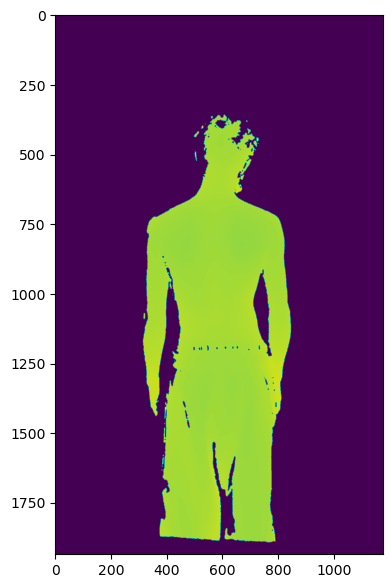

[[ 358  605]
 [ 358  606]
 [ 358  607]
 ...
 [1499  778]
 [1499  779]
 [1499  780]]


In [14]:
z_nobg = median_filter(z_nobg, 5)
plt.imshow(z_nobg)
plt.show()

body = np.argwhere(z_nobg[:1500,:] > 100)
print(body)

[358 605] [1169  315] [1140  845]


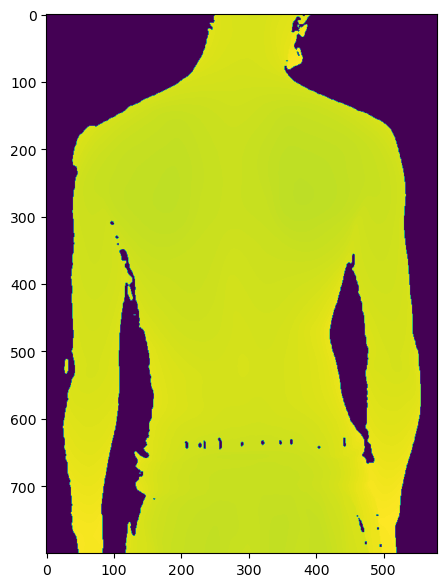

In [18]:
top = body[0]
body_sorted = sorted(body, key=lambda list: list[1])
left = body_sorted[0]
right = body_sorted[-1]
print(top, left, right)

w1 = left[1]-25
w2 = right[1]+25
h1 = top[0]+200
h2 = top[0]+1000

im_crop = z_nobg[h1:h2, w1:w2]
plt.imshow(im_crop)
plt.show()

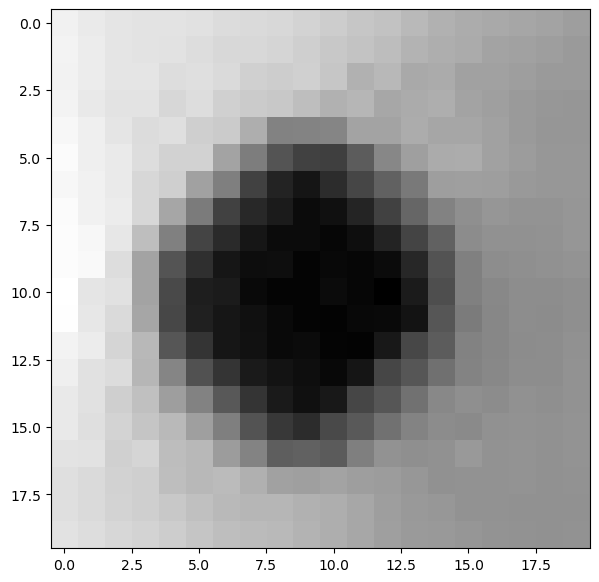

In [18]:
image = cv2.imread('D:\StageE23\Data\Ete_2022\Participant05\BD\Libre\Prise01/Preprocessed/BD_Libre_01_001665_I_0.jpg')
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.imshow(image_bw, cmap='gray')
plt.show()

In [30]:
coordo = {"T1": [281.4342956542969, 118.31011962890625], "T2": [285.3641933287951, 212.79782164737918], "L": [281.432861328125, 352.0157470703125]}
a = np.sqrt((coordo['T1'][0]-coordo['T2'][0])**2+(coordo['T1'][1]-coordo['T2'][1])**2)
b = np.sqrt((coordo['T2'][0]-coordo['L'][0])**2+(coordo['T2'][1]-coordo['L'][1])**2)
c = np.sqrt((coordo['T1'][0]-coordo['T2'][0])**2+(coordo['T1'][1]-coordo['T2'][1])**2)
scoliosis_angle = 180-np.degrees(np.arccos((c**2+b**2-a**2)/(2*a*b)))
print(scoliosis_angle)

137.4218955929418


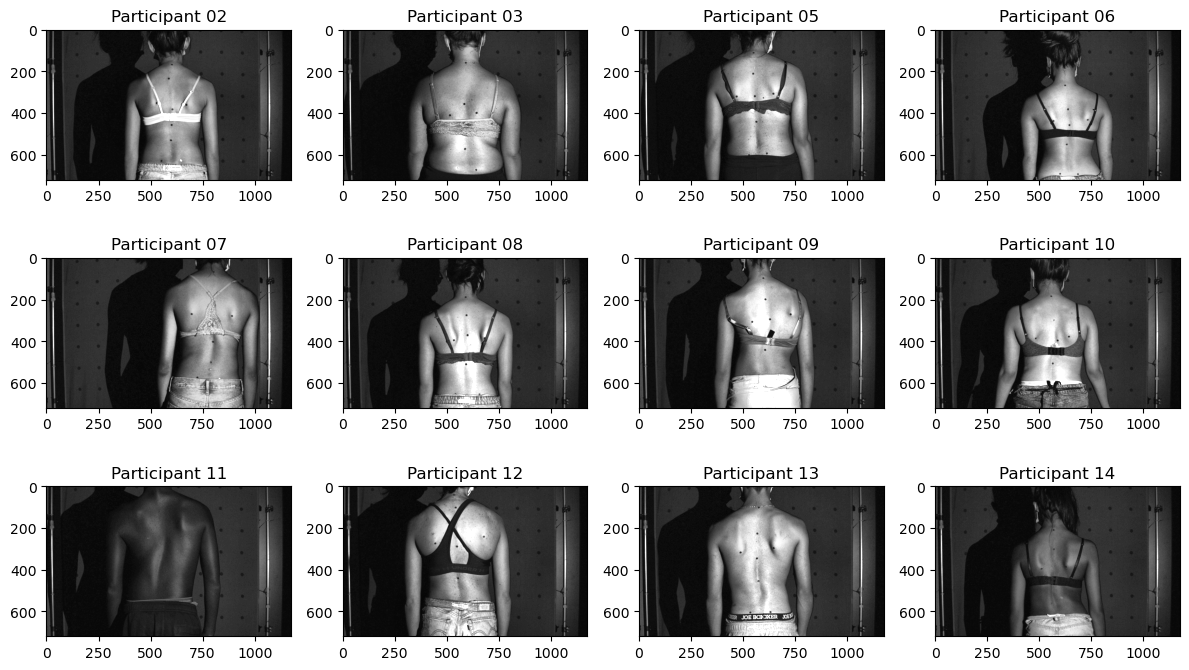

In [33]:
crop = (0, 1176, 560, 1280)
fig, ([ax2, ax3, ax5, ax6], [ax7, ax8, ax9, ax10], [ax11, ax12, ax13, ax14]) = plt.subplots(3,4)

axs = (ax2, ax3, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14)
pt = ['02','03','05','06','07','08','09','10','11','12','13','14']

for i in range(len(pt)):
    path = r'D:\StageE23\Data\Ete_2022\Participant' + pt[i] + r'\autocorrection\Prise02\intensity'
    im = cv2.imread(os.path.join(path, os.listdir(path)[0]))
    image = marker_detection.preprocess(im, crop)[0]
    axs[i].imshow(image, cmap='gray', vmin=0, vmax=180)
    axs[i].set_title(f'Participant {pt[i]}')
plt.tight_layout()
plt.show()

In [14]:
import json

dict_coordo = {}
path = r'D:\StageE23\Data\Ete_2022\Participant06\autocorrection\Prise01'
for filename in os.listdir(path+'\landmarks'):
    coordos = []
    with open(os.path.join(path+'\landmarks', filename), 'r') as f:
        for line in f.readlines():
            coordos.append([line[:line.index(' ')], line[line.index(' '):-2]])
        dict_coordo.update({int(filename[5:-14]): float(coordos[3][0])})

with open(path+'\dict\positions.json', 'w') as positions:
            json.dump(dict_coordo, positions)